# COMP 534 - Applied Artificial Intelligence
## CA2 - Neural network regression
This notebook was produced as a deliverable for a group project for the above module, as part of the 2021-2022 Data Science and Artificial Intelligence MSc course at the University of Liverpool.
### Preparation
#### Setup
Import required libraries, tools and classifiers.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter optimisation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

#### Data
https://www.kaggle.com/datasets/harlfoxem/housesalesprediction

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [3]:
print(df.shape)
df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# id - Unique ID for each home sold
# date - Date of the home sale
# price - Price of each home sold
# bedrooms - Number of bedrooms
# bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower

# sqft_living - Square footage of the apartments interior living space
# sqft_lot - Square footage of the land space
# floors - Number of floors
# waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
# view - An index from 0 to 4 of how good the view of the property was

# condition - An index from 1 to 5 on the condition of the apartment,
# grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
# sqft_above - The square footage of the interior housing space that is above ground level
# sqft_basement - The square footage of the interior housing space that is below ground level
# yr_built - The year the house was initially built

# yr_renovated - The year of the house’s last renovation
# zipcode - What zipcode area the house is in
# lat - Lattitude
# long - Longitude
# sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
# sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

#### Cleaning
no nans  

remove id  
date only over 1 year period, remove?  
price - target feature  
bedrooms - 1x33?! 0x13  
bathrooms - 10x0  

yr renovated - 0 for never and ordinal bins for others? 10 year bins?  
zipcode - drop  
lat - drop?  
long - drop?   

In [5]:
df = pd.read_csv('kc_house_data.csv')
print(df.shape)

df['date'] = pd.to_datetime(df['date'])
df['daysSince'] = (df['date'].max() - df['date']).dt.days

df = df[(df['bedrooms'] > 0) & (df['bedrooms'] < 12)]

df = df[(df['bathrooms'] > 0) & (df['bathrooms'] < 12)]

df = df[df['sqft_lot'] < 5e5]

bins = 9
df['basementOrdinal'] = pd.cut(df[df['sqft_basement']>0]['sqft_basement'], bins, labels=range(1, bins+1)).astype(int)
df['basementOrdinal'] = df['basementOrdinal'].fillna(0)

bins = 9
df['renovatedOrdinal'] = pd.cut(df[df['yr_renovated']>0]['yr_renovated'], bins, labels=range(1, bins+1)).astype(int)
df['renovatedOrdinal'] = df['renovatedOrdinal'].fillna(0)

df = df[df['sqft_lot15'] < 3.5e5]

skewedVariables = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15'] #'price', 
logVariables = ['priceLog', 'sqft_livingLog', 'sqft_lotLog', 'sqft_aboveLog', 'sqft_living15Log', 'sqft_lot15Log'] #'priceLog', 
df[logVariables] = np.log(df[skewedVariables])

df = df.drop(columns=skewedVariables)

df = df.drop(columns=['date', 'id', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'zipcode',])

print(df.shape)

(21613, 21)
(21566, 17)


In [6]:
column_to_move = df.pop("priceLog")

# insert column with insert(location, column_name, column_value)

df.insert(0, "priceLog", column_to_move)

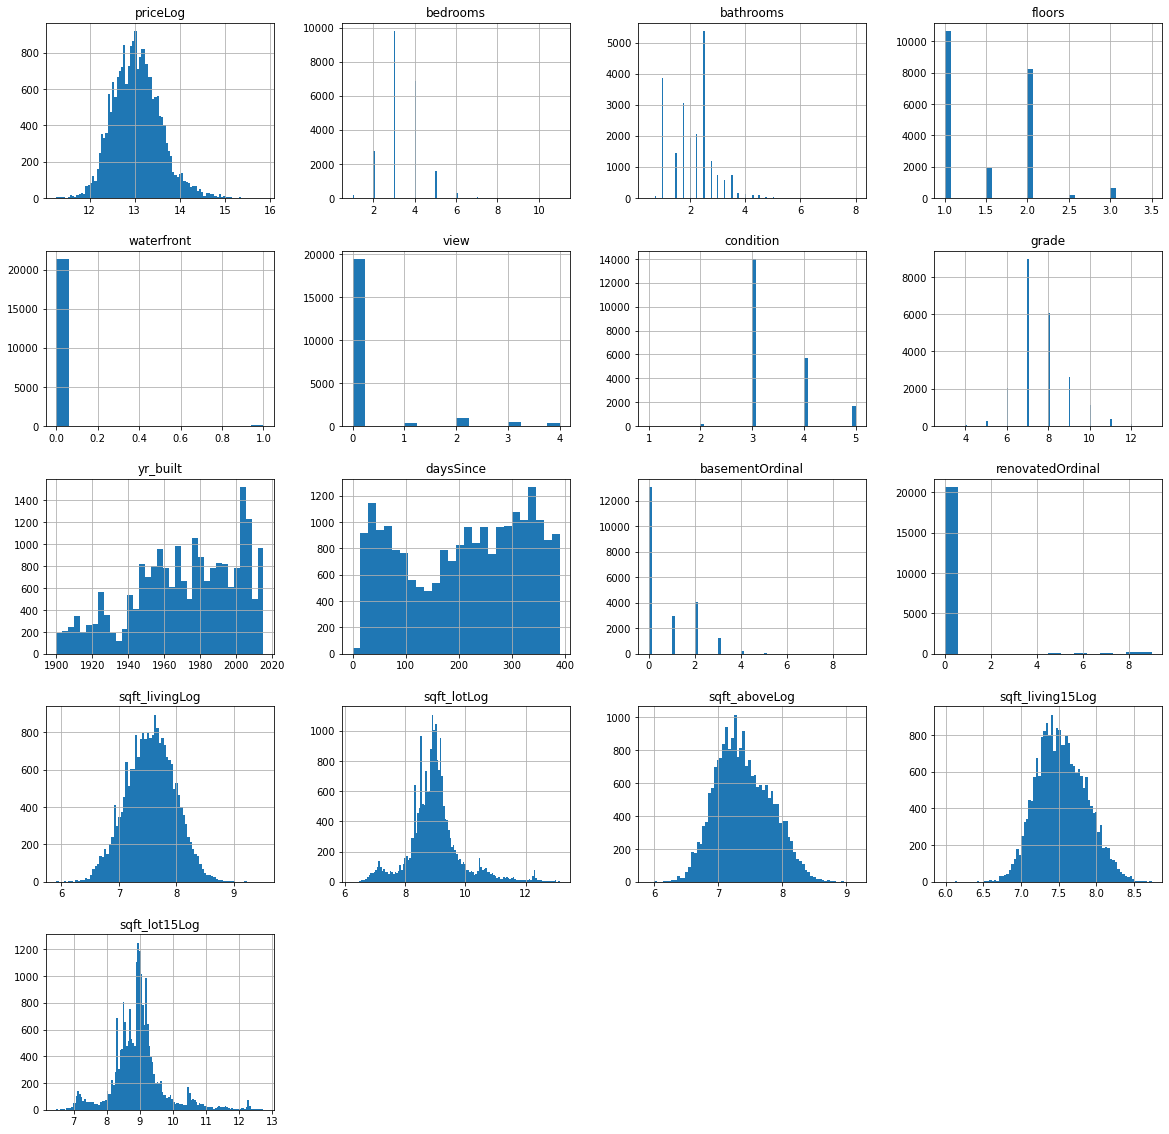

In [7]:
df.hist(bins = "auto", figsize = (20,20))
plt.show()

<AxesSubplot:xlabel='long', ylabel='lat'>

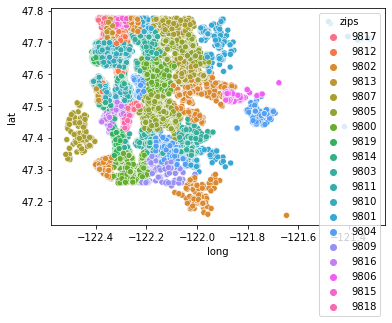

In [131]:
sns.scatterplot(data=df, x='long', y='lat', hue='zips')

In [130]:
df['zips'] = df['zipcode'].astype(str).str[:4]
df['zips'].value_counts()

9805    2573
9811    2426
9803    2268
9800    2247
9810    1830
9802    1819
9807    1383
9812    1053
9804    1047
9813     756
9814     688
9801     599
9819     597
9816     523
9817     517
9815     446
9809     351
9806     307
9818     136
Name: zips, dtype: int64

<AxesSubplot:xlabel='lat', ylabel='Count'>

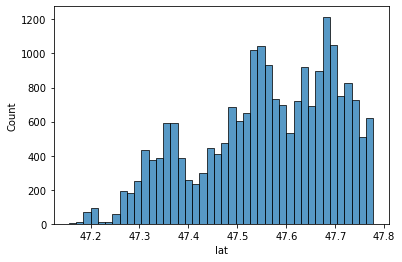

In [132]:
sns.histplot(df['lat'])

<AxesSubplot:xlabel='long', ylabel='Count'>

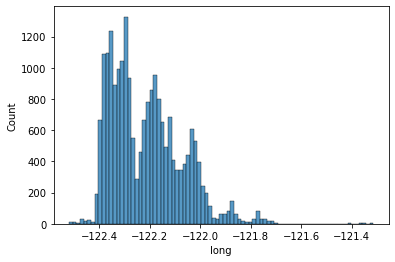

In [133]:
sns.histplot(df['long'])

In [142]:
bins = 10
#df['renovatedOrdinal'] = 
df['latBinned'] = pd.cut(df['lat'], bins, labels=range(bins))#.astype(int)
df['longBinned'] = pd.cut(df['long'], bins, labels=range(bins))#.astype(int)

In [137]:
import tensorflow as tf

In [143]:
df['crossedLatLong'] = tf.feature_column.crossed_column(set([df['latBinned'], df['longBinned']]), hash_bucket_size=1000)
#long_x_lat = tf.feature_column.crossed_column(set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

TypeError: 'Series' objects are mutable, thus they cannot be hashed

### Models and Analysis

In [8]:
from scikeras.wrappers import KerasRegressor

In [9]:
from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [122]:
data = df.values
X = data[:, 1:]
y = data[:, 0].reshape(-1, 1)

In [123]:
# Split data into 80% train and 20% test sets
# Data stratified by class due to imbalance in classes (65% negative - 35% positive)
# Data shuffled to reduce any bias in the order of the dataset
# Define random state to ensure the same train test split can be used for each method
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    #stratify=y,
                                                    shuffle=True,
                                                    #random_state=123,
                                                    )

In [124]:
# Standardise features to negate the impact of different feature units
# Updated features have mean 0 and standard deviation 1
featureScaler = StandardScaler()
featureScaler.fit(X_train[:, -5:])
X_train[:, -5:] = featureScaler.transform(X_train[:, -5:])
X_test[:, -5:] = featureScaler.transform(X_test[:, -5:])

In [125]:
targetScaler = StandardScaler()
targetScaler.fit(y_train)
y_train = targetScaler.transform(y_train)
y_test = targetScaler.transform(y_test)

In [129]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=16,  activation='relu'))
    model.add(Dense(16, input_dim=8, activation='relu'))
    model.add(Dense(1,))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [89]:
from keras.callbacks import EarlyStopping

In [139]:
trainFraction = 0.7
trainingRows = round((X_train.shape[0]*trainFraction))

model = baseline_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

history = model.fit(X_train[:trainingRows],
                    y_train[:trainingRows],
                    validation_data=(X_train[trainingRows:],
                                     y_train[trainingRows:]),
#                     validation_data=(X_test,
#                                      y_test),
                    epochs=1000,
                    batch_size=16,
                    verbose=0,
                    callbacks=[es],
                   )

train_acc = model.evaluate(X_train[:trainingRows],
                              y_train[:trainingRows],
                              verbose=0)
valid_acc = model.evaluate(X_train[trainingRows:],
                             y_train[trainingRows:],
                             verbose=0)

print(f'Train: {train_acc:.3f}\nValid: {valid_acc:.3f}')


# verbose=0)
#y_pred = model.predict(X_test)

Epoch 00147: early stopping
Train: 0.398
Valid: 0.399


In [96]:
history.history['loss']

[566.6356201171875,
 102.04937744140625,
 14.458999633789062,
 1.8235796689987183,
 0.7879676222801208,
 0.6968598961830139,
 0.6564887166023254,
 0.6353110074996948,
 0.6223079562187195,
 0.6106947660446167,
 0.6032736897468567,
 0.6098137497901917,
 0.5951381921768188,
 0.5900056958198547,
 0.5983498096466064,
 0.5924223065376282,
 0.581139862537384,
 0.5727225542068481,
 0.5795022249221802,
 0.5609262585639954,
 0.5535727739334106,
 0.5571979880332947,
 0.5715082287788391,
 0.5645062327384949,
 0.5798799991607666,
 0.5673622488975525,
 0.5409913063049316,
 0.5579092502593994,
 0.5624051094055176,
 0.5407550930976868,
 0.6304482817649841,
 0.5177605152130127,
 0.5409262776374817,
 0.538252592086792,
 0.5760754346847534,
 0.5261964797973633,
 0.5420902371406555,
 0.5439633131027222,
 0.5558096170425415,
 0.6190410852432251,
 0.5633044242858887,
 0.5777661800384521,
 0.5987217426300049,
 0.5489718914031982,
 0.5957660675048828,
 0.520808219909668,
 0.5004146099090576,
 0.55410194396972

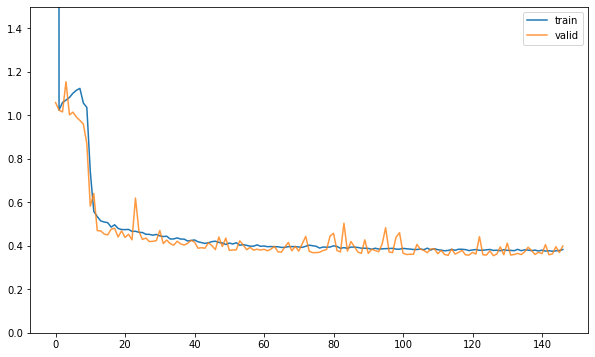

In [140]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='valid', alpha=0.8)

#ax.set(yscale="log") #xscale="log", 

ax.set_ylim([0, 1.5])

plt.legend()
plt.show()

1. Learning Rate
2. Batch Size
3. Number of epochs
4. Activation functions
5. Optimizers
6. Loss function
7. Number of Hidden Layers
8. Number of nodes in the hidden layers

In [135]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

### Search space

In [146]:
# Function to optimise algorithm hyperparameters
# Performs grid search with cross validation to evaluate hyperparameter combinations
# Takes:
# - algorithm: machine learning model object
# - searchSpace: dictionary containing hyperparameter names (keys) and list of values to search through (values)
# - X_train: training data feature values
# - y_train: training data class labels
def hyperparameterTuner(algorithm, searchSpace, X_train, y_train):
    # Initialise cross validator
    # Repeated to account for variance across samples
    # Stratified to ensure constant proportion of each classes in each fold
    crossValidator = RepeatedKFold(n_splits=7, random_state=1, n_repeats=2)
    # Initialise search
    # Grid search to perform exhaustive search of all hyperparameter combinations in searchSpace
    hyperparameterSearch = GridSearchCV(algorithm, searchSpace, scoring='neg_mean_squared_error', n_jobs=-1, cv=crossValidator)
    # Fit search with training data
    # Performs search over searchSpace
    hyperparameterSearch.fit(X_train, y_train)
    return hyperparameterSearch

In [141]:
searchSpace = {
    'epochs': [3,4,5], # 'n_neighbors': 5,
}

In [142]:
# Create KNN classifier for hyperparameter search
#knnSearchModel = KNeighborsClassifier()
searchEstimator = KerasRegressor(model=baseline_model, verbose=0)

In [147]:
#model=baseline_model()
# Perform search based on search space
search = hyperparameterTuner(searchEstimator, searchSpace, X_train, y_train)

In [148]:
# Store best parameters found
optimumParameters = search.best_params_
print(optimumParameters)
# Store all results in new dataframe
results = pd.DataFrame(search.cv_results_)
results

{'epochs': 3}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epochs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,3.683489,0.476964,0.444135,0.187180,3,{'epochs': 3},-0.483035,-0.431546,-0.441727,-0.459040,...,-0.468198,-0.455249,-0.444415,-0.470607,-0.461801,-0.520150,-0.427026,-0.464949,0.030499,1
1,4.554236,0.786990,0.486908,0.216289,4,{'epochs': 4},-0.457053,-0.406348,-0.430372,-0.573986,...,-0.568763,-0.448839,-0.424048,-0.410632,-0.506927,-0.468984,-0.442167,-0.497510,0.153288,3
2,5.683528,0.784588,0.457331,0.240215,5,{'epochs': 5},-0.492634,-0.986673,-0.451171,-0.455137,...,-0.438428,-0.428122,-0.431568,-0.408255,-0.482624,-0.435837,-0.419209,-0.487709,0.140980,2


In [126]:
# evaluate model
estimator = KerasRegressor(model=baseline_model, epochs=5, batch_size=10, verbose=0)
kfold = KFold(n_splits=2)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: 0.57 (0.00) MSE


#### Test

In [141]:
y_pred = model.predict(X_test)

In [142]:
# invert transform on predictions
#yhat = model.predict(test_X)
y_test = targetScaler.inverse_transform(y_test)
y_pred = targetScaler.inverse_transform(y_pred)

In [143]:
y_test = y_test.reshape(y_test.shape[0])
y_pred = y_pred.reshape(y_pred.shape[0])

In [148]:
y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

Text(0, 0.5, 'Prediction')

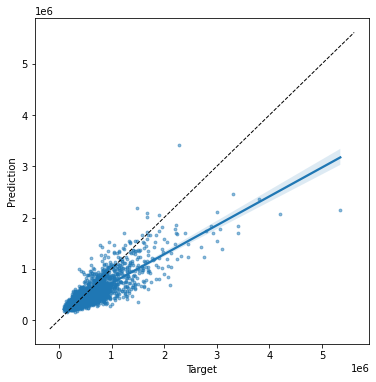

In [170]:
fig, ax = plt.subplots(figsize=(6,6))

ax = sns.regplot(x=y_test,
                 y=y_pred,
                 scatter_kws={'s':8,
                              'alpha':0.5},                
               )

#ax.set(xscale="log", yscale="log")

xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1)#, scalex=False, scaley=False)

#ax = sns.lineplot(x=[0,1], y=[0,1])#, transform=ax.transAxes)

#ax.axis('equal')

ax.set_xlabel('Target')
ax.set_ylabel('Prediction')

In [146]:
from sklearn.metrics import mean_squared_error

In [150]:
errors = mean_squared_error(y_test, y_pred)
print(errors)

47058438818.80368
